In [1]:
import numpy as np
from numpy import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def d_poly__d_x(x, t, period=1000):
    a1 = 0
    a2 = -3.2
    sin_scale = 3
    a3 = sin_scale*np.sin(2*np.pi*t/period)
    a4 = 0.1
    a5 = -(3/5) * a3
    a6 = 1

    all_scale = 1
    
    return all_scale*(a6*6*x**5 + a5*5*x**4 + a4*4*x**3 + a3*3*x**2 + a2*2*x + a1) 

def F_constant(t, alpha, T_start, T_end):
    return alpha

def F_linear(t, alpha, T_start, T_end):
    if T_start != -1 and T_end != -1:
        x=0
        if t >= T_start and t <= T_end:
            x += 1
            return alpha * x
        if t > T_end:
            return 0
    else:
        return alpha * t

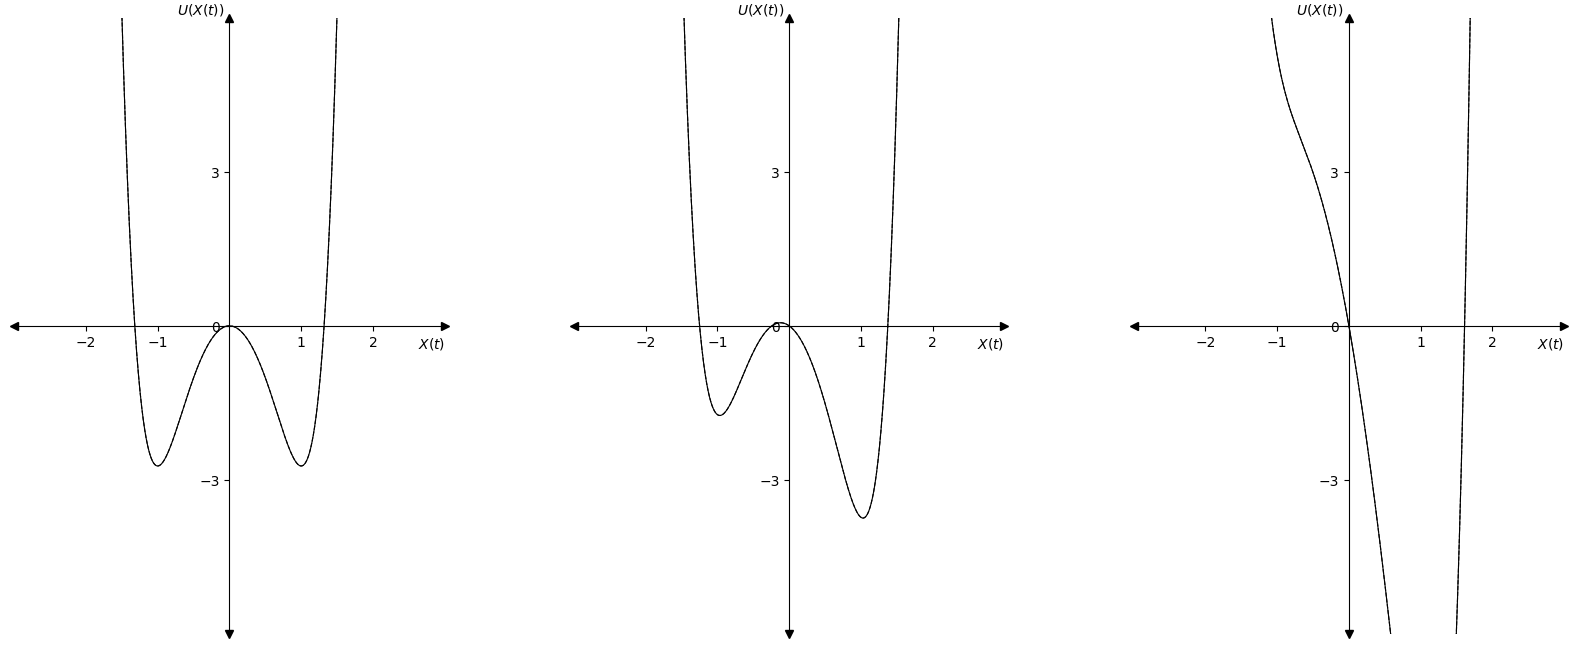

In [30]:
## Potentials ##
num_steps = 10000

def int_pot(x, a_6=1, a_2=-3.2, t=0, period=1000):
    beta = 3
    a_3 = beta * np.sin(2*np.pi * t/period)
    a_5 = (-3/5)*a_3
    a_4 = (-3*a_6 - a_2)/2
    all_scale = 1.3
    return all_scale * (a_6 * x**6 + a_5 * x**5 + a_4 * x**4 + a_3 * x**3 + a_2 * x**2) - (x*F_linear(t,0.001,-1,-1))

x = np.linspace(-2, 2, num_steps)
time_points = [0, 1000, 8000]

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3)  # Adjust spacing between plots

# Common styling function
def style_subplot(ax, t):
    ax.set_ylim((-6, 6))
    ax.set_xlim((-3, 3))
    ax.set_xticks([-2, -1, 1, 2])
    ax.set_yticks([-3, 0, 3])
    ax.set_xlabel(r'$X(t)$', loc='right', labelpad=-10)
    ax.set_ylabel(r'$U(X(t))$', loc='top', rotation=0, labelpad=-18)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Add arrows
    ax.plot((0), (1), '^k', transform=ax.get_xaxis_transform(), clip_on=False)
    ax.plot((0), (0), 'vk', transform=ax.get_xaxis_transform(), clip_on=False)
    ax.plot((1), (0), '>k', transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot((-0), (0), '<k', transform=ax.get_yaxis_transform(), clip_on=False)
    
    # ax.set_title(f'$t={t}$')

# Plot for each time point
for i, t in enumerate(time_points):
    axes[i].plot(x, int_pot(x, t=t), 'k-', linewidth=0.8)
    axes[i].plot(x, int_pot(x, t=t), 'k--', linewidth=0.8)
    style_subplot(axes[i], t)
plt.show()

In [3]:
# Approximate solution to polynomial #
def f(x):
    return 30*x**4 - 36*x**3 + 1.2*x**2 + 18*x - 6.4

def bisection(a, b, tol=1e-7, max_iter=1000):
    fa = f(a)
    fb = f(b)
    if fa * fb > 0:
        raise ValueError("The function must have opposite signs at a and b.")
    
    for _ in range(max_iter):
        c = (a + b) / 2
        fc = f(c)
        # Check if the function value is close enough to zero or the interval is sufficiently small
        if abs(fc) < tol or (b - a) / 2 < tol:
            return c
        # Determine the subinterval that contains the root
        if fa * fc < 0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
    raise RuntimeError("did not converge within the maximum number of iterations.")

root = bisection(-1, 0)
print("The root is approximately: {:.6f}".format(root))


The root is approximately: -0.684872


In [4]:
def euler_maruyama_EM_F(X0, dt, epsilon, U_prime, num_steps, num_trajectories, dW, F, alpha, T_start, T_end):

    if num_trajectories == 1:
        X = np.zeros(num_steps + 1)
    else:
        X = np.zeros((num_steps + 1, num_trajectories))
    
    # Set initial condition
    X[0] = X0
    
    for n in range(num_steps):

        t = n * dt
        
        drift = -U_prime(X[n], t) + F(t, alpha, T_start, T_end)
        
        #dW = np.sqrt(dt) * np.random.randn(num_trajectories) if num_trajectories > 1 else np.sqrt(dt) * np.random.randn()
        
        X[n+1] = X[n]  + drift * dt + np.sqrt(epsilon) * dW[n]
    
    return X

def euler_maruyama_EM(X0, dt, epsilon, U_prime, num_steps, num_trajectories, dW):

    if num_trajectories == 1:
        X = np.zeros(num_steps + 1)
    else:
        X = np.zeros((num_steps + 1, num_trajectories))
    
    # Set initial condition
    X[0] = X0
    
    for n in range(num_steps):

        t = n * dt
        
        drift = -U_prime(X[n], t)
        
        #dW = np.sqrt(dt) * np.random.randn(num_trajectories) if num_trajectories > 1 else np.sqrt(dt) * np.random.randn()
        
        X[n+1] = X[n]  + drift * dt + np.sqrt(epsilon) * dW[n]
    
    return X

In [4]:
# Parameters
X0 = 0              
dt = 0.01             # time step
T_total = 10000       # total simulation time
epsilon = 0.5         # noise strength
N = 1000              # number of trajectories to simulate per candidate F0
target_prob = 1e-4    # target escape probability threshold
num_steps = int(T_total / dt)

dW = np.sqrt(dt) * np.random.randn(num_steps+1, N)

def compute_escape_prob(F0):
    # Run the simulation for this parameter pair
    positions = euler_maruyama_EM_F(X0, dt, epsilon, d_poly__d_x, num_steps, N, dW, F_constant, F0, -1, -1)
    size = positions.size
    escapes = np.sum(positions < 0)
    return escapes / size

# Binary search for the minimal F0 
F_low = 0.0
F_high = 7.2696
tol = 1e-4  # tolerance for F0

while F_high - F_low > tol:
    F_mid = (F_low + F_high) / 2.0
    prob_escape = compute_escape_prob(F_mid)
    print(f"F0 = {F_mid:.4f}, Escape Prob = {prob_escape:.6e}")
    # If escape probability is higher than our target, forcing is too weak
    if prob_escape > target_prob:
        F_low = F_mid
    else:
        F_high = F_mid

F_min = (F_low + F_high) / 2.0

print("\nMinimal F0 required to stabilize x=1:")
print(f"F0 = {F_min:.4f}")

F0 = 3.6348, Escape Prob = 1.979998e-06
F0 = 1.8174, Escape Prob = 2.744241e-03
F0 = 2.7261, Escape Prob = 2.220498e-05
F0 = 2.2717, Escape Prob = 2.956817e-04
F0 = 2.4989, Escape Prob = 8.719591e-05
F0 = 2.3853, Escape Prob = 1.046839e-04
F0 = 2.4421, Escape Prob = 9.319491e-05
F0 = 2.4137, Escape Prob = 9.570190e-05
F0 = 2.3995, Escape Prob = 9.701290e-05
F0 = 2.3924, Escape Prob = 9.710290e-05
F0 = 2.3889, Escape Prob = 1.046509e-04
F0 = 2.3907, Escape Prob = 9.715490e-05
F0 = 2.3898, Escape Prob = 1.046419e-04
F0 = 2.3902, Escape Prob = 9.723190e-05
F0 = 2.3900, Escape Prob = 1.046389e-04
F0 = 2.3901, Escape Prob = 1.046369e-04
F0 = 2.3902, Escape Prob = 1.046369e-04

Minimal F0 required to stabilize x=1:
F0 = 2.3902


In [9]:
X0 = 0
dt = 0.01
T = 10000
start = -1
end = -1
epsilon = 0.5
alpha = 0.9
num_steps = int(T/dt)
num_trajectories = 1
dW = [np.sqrt(dt) * np.random.randn() for _ in range(num_steps)]

X_em_F = euler_maruyama_EM_F(X0, dt, epsilon, d_poly__d_x, num_steps, num_trajectories, dW, F_constant, alpha, start, end)
X_em = euler_maruyama_EM(X0, dt, epsilon, d_poly__d_x, num_steps, num_trajectories, dW)

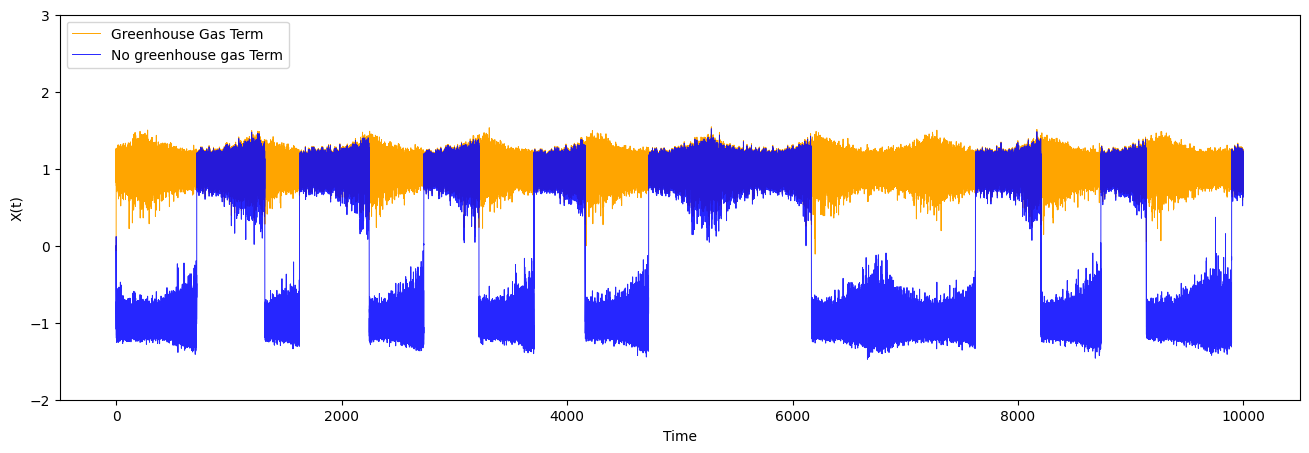

In [10]:
time = np.linspace(0, T, num_steps+1)
plt.figure(figsize=(16, 5))
plt.plot(time, X_em_F, color='orange', linewidth=0.7, label='Greenhouse Gas Term')
plt.plot(time, X_em, color='b', alpha=0.85, linewidth=0.7, label='No greenhouse gas Term')
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend(loc='upper left')
plt.ylim(-2, 3)
plt.show()

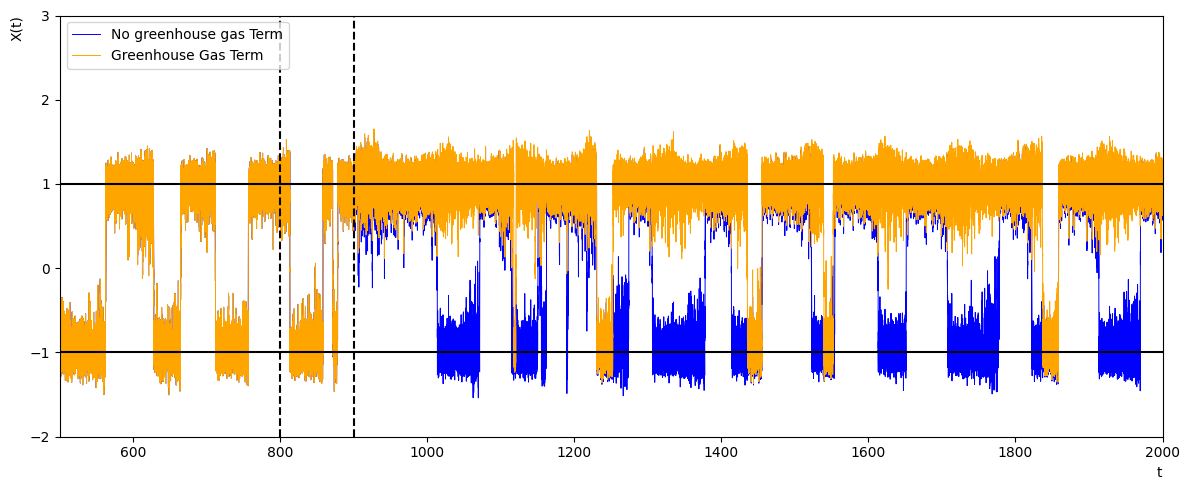

In [55]:
plt.figure(figsize=(12, 5))

# Plot the two trajectories
plt.plot(time, X_em, color='blue', linewidth=0.7, label='No greenhouse gas Term')
plt.plot(time, X_em_F, color='orange', linewidth=0.7, label='Greenhouse Gas Term')

# Add horizontal lines at X(t) = ±1
plt.axhline(y=1, color='black', linestyle='-')
plt.axhline(y=-1, color='black', linestyle='-')

# Add vertical lines at t = 800 and t = 900
plt.axvline(x=800, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')

# Show only the second half of the trajectory on the x-axis
plt.xlim(500, 2000)
plt.ylim(-2, 3)

# Labels, title, legend
plt.xlabel('t', loc='right')
plt.ylabel('X(t)', loc='top')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [10]:
X0 = 0
dt = 0.01
T = 20000
start = -1
end = -1
epsilon = 0.5
alpha = 0.5
num_steps = int(T/dt)
num_trajectories = 1
dW = [np.sqrt(dt) * np.random.randn() for _ in range(num_steps)]

X_em_F = euler_maruyama_EM_F(X0, dt, epsilon, d_poly__d_x, num_steps, num_trajectories, dW, F_constant, alpha, start, end)

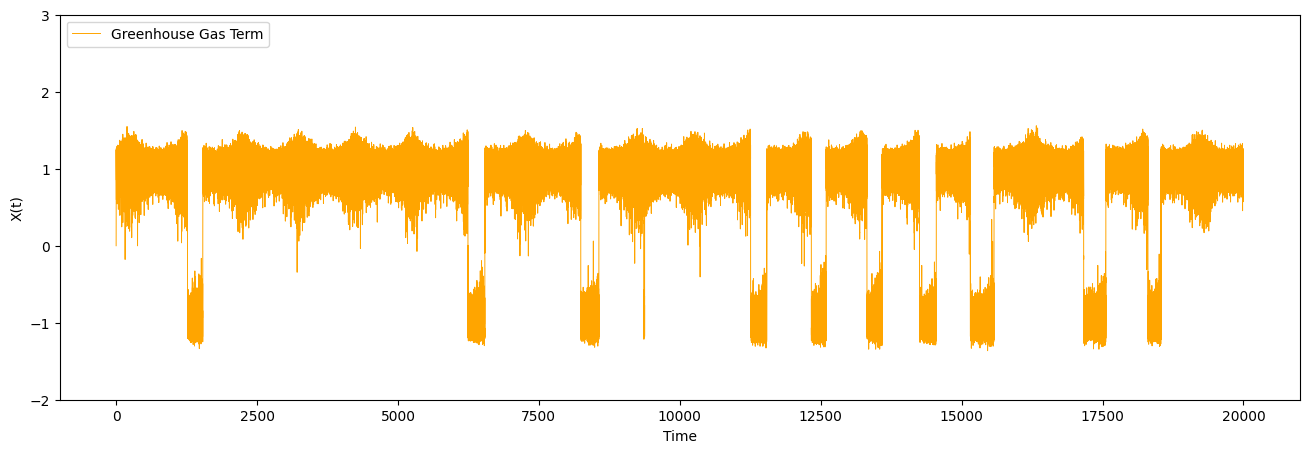

In [11]:
time = np.linspace(0, T, num_steps+1)
plt.figure(figsize=(16, 5))
plt.plot(time, X_em_F, color='orange', linewidth=0.7, label='Greenhouse Gas Term')
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend(loc='upper left')
plt.ylim(-2, 3)
plt.show()